In [1]:
import qiskit
from qiskit.quantum_info import state_fidelity
import numpy as np
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt

import sys
sys.path.append("../../src/groundstate_prep")
from ground_state_prep_qiskit import qetu_rqc_oneLayer


# Parameters for the Ising Hamiltonian
# L has to be even! Due to K only being able to control even Ls!
L, J, g = (10, 1, 1)

# construct Hamiltonian
latt = qib.lattice.IntegerLattice((L,), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
hamil = qib.IsingHamiltonian(field, J, 0, g).as_matrix().toarray()

eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
print("Ground State Energy", -eigenvalues_sort[-1].real)

dist = 1e-5

# Apriori Knowledge!
max_spectrum_length = 40
spectrum_lower_bound = -20

c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * spectrum_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
print("t: ", c1/2)

print(a_values[:5])
print(eigenvalues_sort[:5])

/opt/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/anaconda3/envs/qc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Ground State Energy -12.784906442999349
t:  0.039269658169872414
[0.96012726-0.j 0.9583809 -0.j 0.94523441-0.j 0.94339972-0.j
 0.94339972-0.j]
[-12.78490644+0.j -12.62750303+0.j -11.53343072+0.j -11.39143505+0.j
 -11.39143505+0.j]


Initial overlap:  0.0012402347206191312


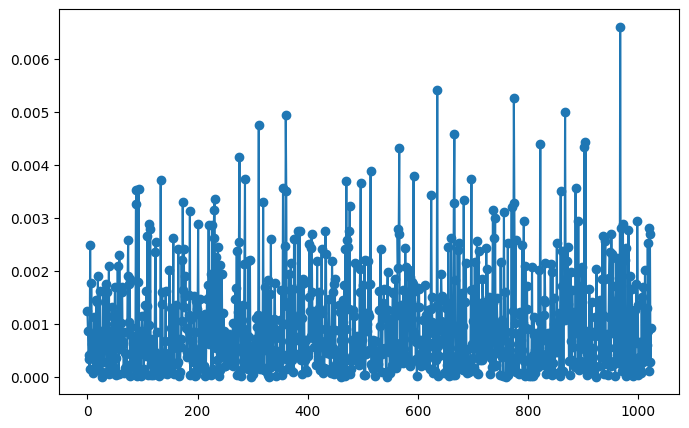

In [87]:
# We randomize the initial state

from qiskit.quantum_info import random_statevector

vec = random_statevector(2**L)
toPlot = [state_fidelity(vec, eigenvectors_sort[:, i]) for i in range(2**L)]
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)
print("Initial overlap: ", state_fidelity(vec, eigenvectors_sort[:, 0]))

plt.show()

dt:  0.039269658169872414
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.44505872131773105+0j)
F(a_premax)^2:  (0.39548318935012583+0j)
F(x)^2:  0.197088896159272


/var/folders/l5/dy5jxrx94_98nf6d030tcw640000gn/T/ipykernel_39905/3716621348.py:19: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.0014236020477074037
Success Prob:  0.27508309617230914
Overlaps:  [0.6271247768212692, 0.34440451419427387, 0.012377550994207013]


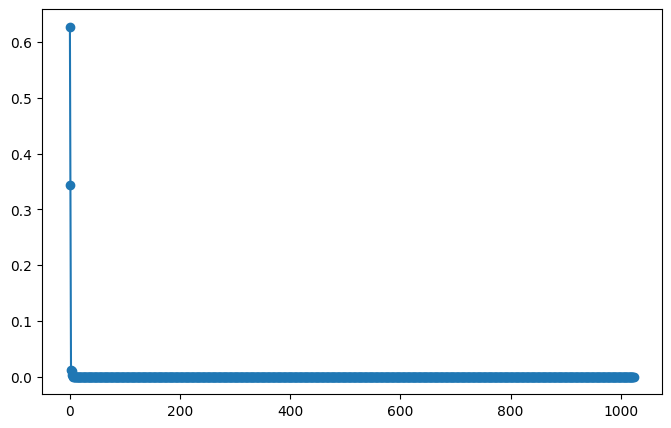

In [88]:
from qiskit import Aer, execute, transpile

ket_0 = np.array([1,0])
qcs_qetu = []

mu, d, c, phis_max_iter, = (0.95, 30, 0.95, 10)
qc_qetu, phis_0, _ = qetu_rqc_oneLayer(L, J, g, c1/2, mu, a_values, d=d, c=c, 
                                           c2=c2, max_iter_for_phis=phis_max_iter, 
                                           reuse_RQC=6)
qcs_qetu.append(qc_qetu)
qcs_qetu.append(qc_qetu)
ground_state = eigenvectors_sort[:, 0]

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, L+1)
qc_RQC.initialize(np.kron(ket_0, vec))
for qc_qetu in qcs_qetu:
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    print("Success Prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)


toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(2**L)]
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)

print("Overlaps: ", toPlot[0:3])
plt.show()

In [89]:
sys.path.append("../../src/profiling")
from profiling import moment


D, beta = (7, 50)
strech = 1

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, 1)
qc_RQC.initialize(np.kron(ket_0, vec))


for qc_qetu in qcs_qetu:
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    print("Success Prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)

c1 = 2/(max_spectrum_length)
c1 = c1 * strech

/var/folders/l5/dy5jxrx94_98nf6d030tcw640000gn/T/ipykernel_39905/703404488.py:15: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.0014236020477074037
Success Prob:  0.27508309617230914


In [4]:
moments = [moment(qc_RQC, L, J, g, eigenvalues_sort, k, c1, c2=0,
                  shots=1e3, depolar=1e-10
                 ) if k%2==1 else 0 for k in range(1, D+1)]

mom_b = [np.conj(moment) for moment in moments]
mom_b.reverse()
moments = mom_b + [1] + moments

/var/folders/l5/dy5jxrx94_98nf6d030tcw640000gn/T/ipykernel_39905/737276809.py:15: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.0009648033003277033
Success Prob:  0.16042947524051637
t:  0.025
dt:  0.025
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cu', 'u3', 'u2', 'cx', 'cy', 'cz']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.07500000000000001
dt:  0.07500000000000001
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cu', 'u3', 'u2', 'cx', 'cy', 'cz']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.125
dt:  0.125
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cu', 'u3', 'u2', 'cx', 'cy', 'cz']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.17500000000000002
dt:  0.17500000000000002
nsteps:  1
NoiseModel:
  Basis gates: ['cu',

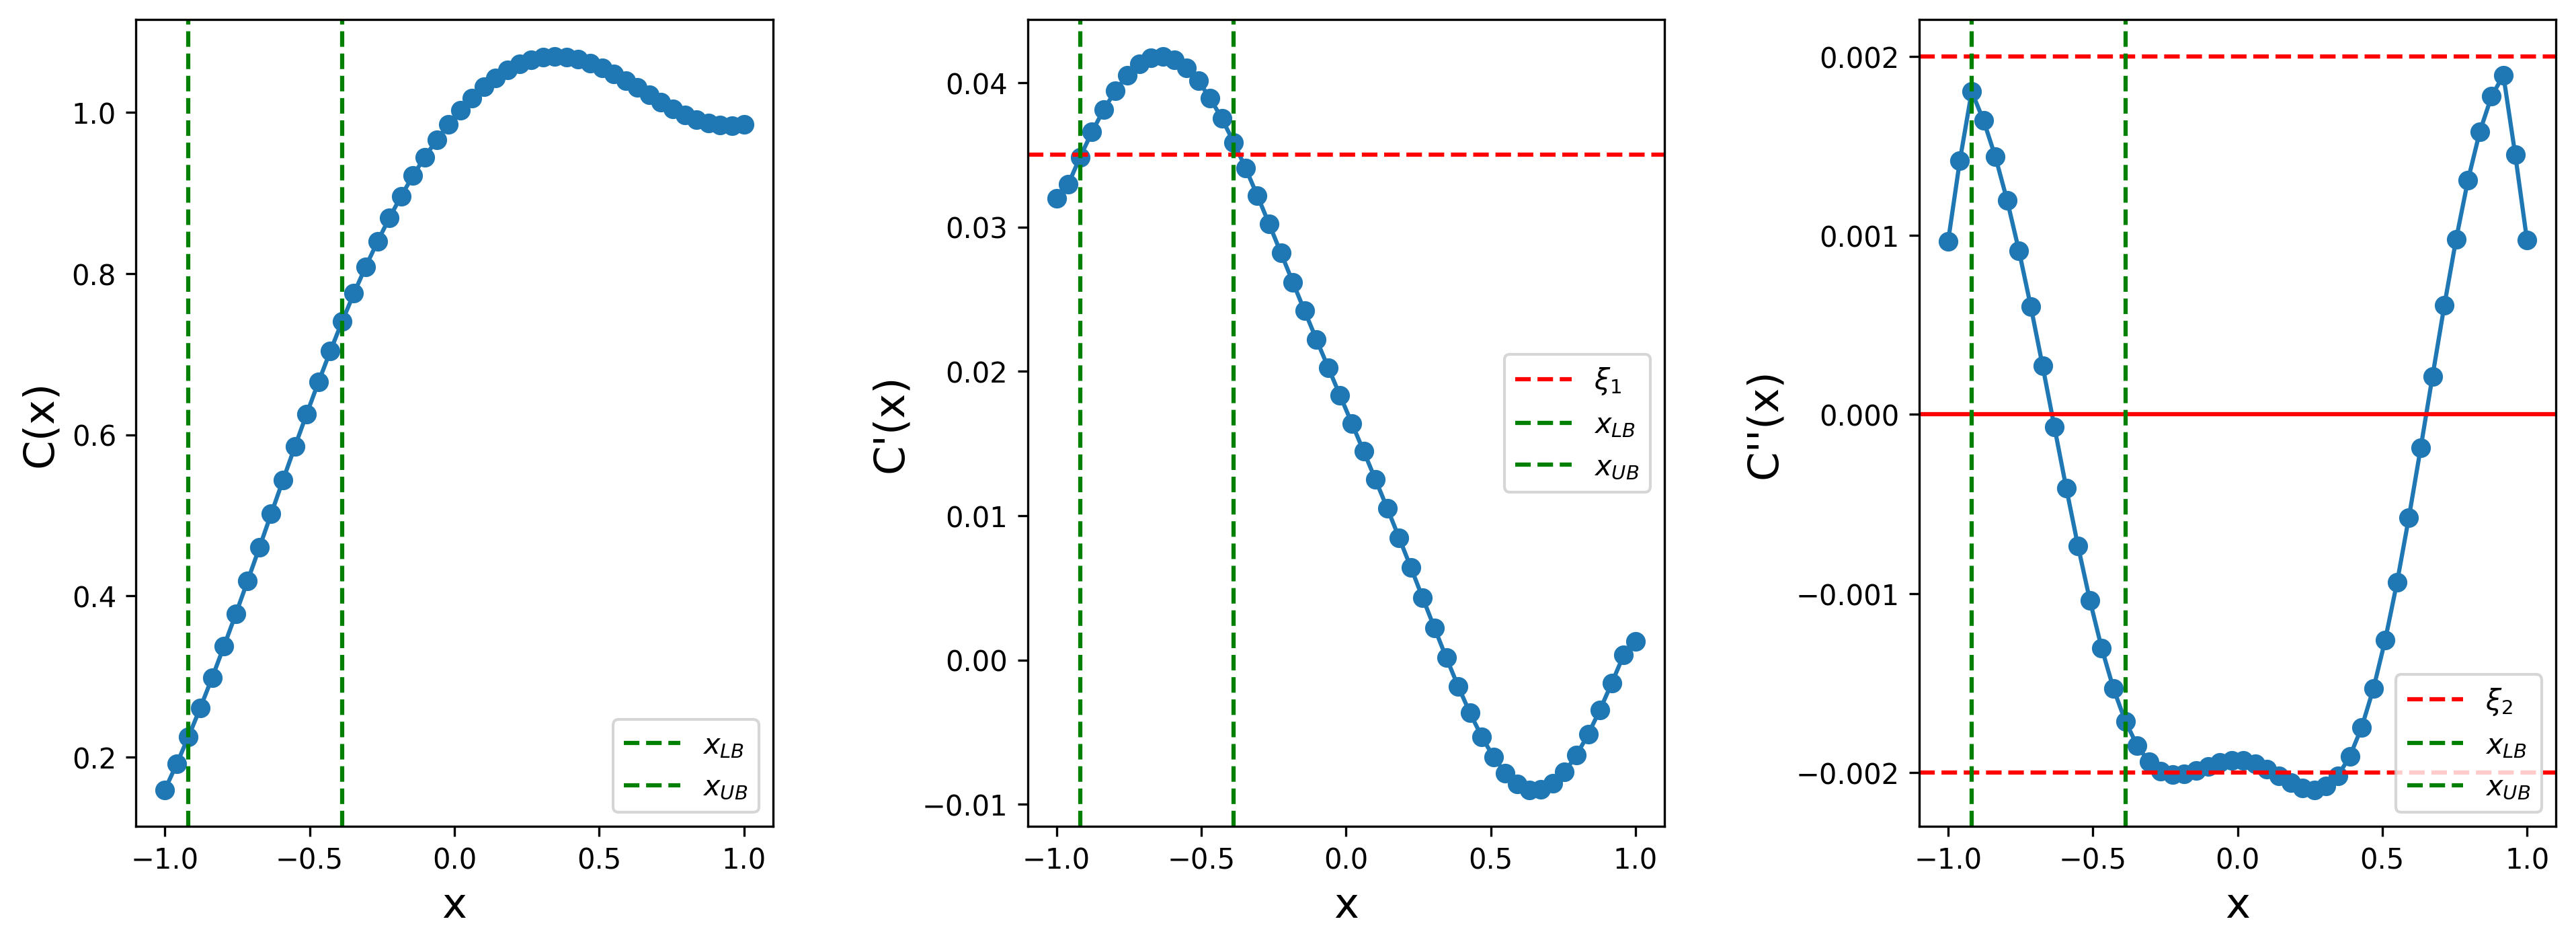

In [14]:
from profiling import C

x_values = np.linspace(-1, 1, 50)
cdf = [C(x, D, moments, beta=beta) for x in x_values]

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.rcParams["figure.figsize"] = (15,5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plt.subplot(131)
plt.plot(x_values, cdf)
plt.scatter(x_values, cdf)
plt.axvline(x_values[2], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[15], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C(x)", size=15)
plt.legend()


plt.subplot(132)
cdf_dot = np.gradient(cdf)
plt.plot(x_values, cdf_dot)
plt.scatter(x_values, cdf_dot)
plt.axhline(0.035, color="red", ls="--", label=r"$\xi_1$")
plt.axvline(x_values[2], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[15], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C'(x)", size=15)
plt.legend()

plt.subplot(133)
cdf_dot2 = np.gradient(cdf_dot)
plt.plot(x_values, cdf_dot2)
plt.axhline(0, color="red")
plt.axhline(2e-3, color="red", ls="--", label=r"$\xi_2$")
plt.axhline(-2e-3, color="red", ls="--")
plt.scatter(x_values, cdf_dot2)
plt.axvline(x_values[2], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[15], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C''(x)", size=15)
plt.legend()

plt.show()
#plt.savefig("../../theory/pdf2/cdf1_L10.pdf")

In [21]:
x_values = np.linspace(-1, 1, 50)
print("Estimated new spectrum:", np.array([x_values[2], x_values[15]])/c1, "\n")
print(eigenvalues_sort[:7] * c1)

Estimated new spectrum: [-18.36734694  -7.75510204] 

[-0.63924532+0.j -0.63137515+0.j -0.57667154+0.j -0.56957175+0.j
 -0.56957175+0.j -0.51716033+0.j -0.51716033+0.j]


In [51]:
# Assumptions!
spectrum_upper_bound = -7.75510204
spectrum_lower_bound = -18.36734694
max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * spectrum_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
print(a_values[:5])
print(eigenvalues_tr[:6])
print("t: ", c1/2)
print("c2: ", c2)

# In the first adaptive filtering we choose one quarter of the growing region!
print("Mu: ", np.cos((c1*(max_spectrum_length * 0.55 + spectrum_lower_bound)+c2)/2) )

[0.67760312-0.j 0.66028657-0.j 0.53055877-0.j 0.51262729-0.j
 0.51262729-0.j]
[1.65259553+0.j 1.69919211+0.j 2.02307341+0.j 2.06510878+0.j
 2.06510878+0.j 2.3754188 +0.j]
t:  0.14801640384259285
c2:  5.437347284376104
Mu:  0.6494484285330855


In [23]:
mu, d, c, phis_max_iter, = (0.6, 30, 0.95, 10)
qc_qetu, phis_0, _ = qetu_rqc_oneLayer(L, J, g, c1/2, mu, a_values, d=d, c=c, 
                                           c2=c2, max_iter_for_phis=phis_max_iter,
                                           reuse_RQC=6)
qcs_qetu.append(qc_qetu)

dt:  0.14801640384259285
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.8788027545174327+0j)
F(a_premax)^2:  (0.8071783621613926+0j)
F(x)^2:  0.2494342153701369


/var/folders/l5/dy5jxrx94_98nf6d030tcw640000gn/T/ipykernel_39905/1149232483.py:9: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.0009648033003277033
Success Prob:  0.16042947524051637
Success Prob:  0.7486020659342043
Overlaps:  [0.3153017025436835, 0.6840272688299988, 0.00013383185415223153]


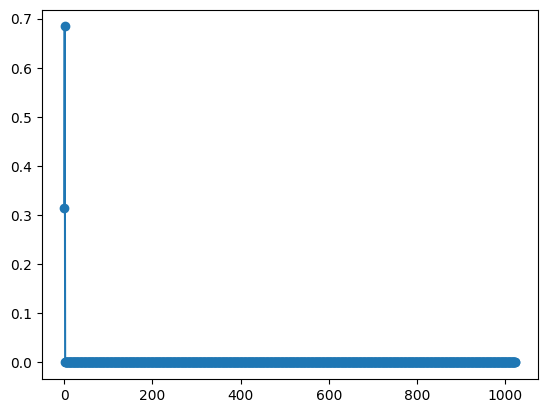

In [49]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, L+1)
qc_RQC.initialize(np.kron(ket_0, vec))
for qc_qetu in qcs_qetu[:3]:
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    print("Success Prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)

toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(2**L)]
print("Overlaps: ", toPlot[0:3])
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)
plt.show()

In [52]:
D, beta = (7, 50)

strech = 1
c1 = 2/(max_spectrum_length)
c1 = c1 * strech
c2 =  - c1 * spectrum_lower_bound - 1
eigenvalues_tr = eigenvalues_sort * c1 + c2
print(eigenvalues_tr[:6])

psi = np.sqrt(toPlot[0]) * eigenvectors_sort[:, 0]
for i in range(1, 2**L):
    psi = psi + np.sqrt(toPlot[i]) * eigenvectors_sort[:, i]
psi = psi/np.linalg.norm(psi)

[0.05207532+0.j 0.08173981+0.j 0.28793036+0.j 0.31469109+0.j
 0.31469109+0.j 0.51224184+0.j]


In [53]:
print("c1: ", c1)

moments = [moment(qc_RQC, L, J, g, eigenvalues_sort, k, c1, c2=0, psi=psi,
                  shots=1e3, depolar=1e-10
                 ) if k%2==1 else 0 for k in range(1, D+1)]
mom_b = [np.conj(moment) for moment in moments]
mom_b.reverse()
moments = mom_b + [1] + moments
moments

c1:  0.18846153842529587
t:  0.09423076921264793
dt:  0.09423076921264793
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cu', 'u3', 'u2', 'cx', 'cy', 'cz']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.2826923076379438
dt:  0.2826923076379438
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cu', 'u3', 'u2', 'cx', 'cy', 'cz']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.4711538460632397
dt:  0.4711538460632397
nsteps:  1
NoiseModel:
  Basis gates: ['cu', 'cx', 'cy', 'cz', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'cu', 'u3', 'u2', 'cx', 'cy', 'cz']
  All-qubits errors: ['u1', 'u2', 'u3', 'cu', 'cx', 'cy', 'cz']
getting counts
t:  0.6596153844885355
dt:  0.6596153844885355
nsteps:  1
NoiseModel:
  Basis gates: ['c

[(-0.46599999999999997+0.8360000000000001j),
 0,
 (0.81+0.558j),
 0,
 (0.6639999999999999-0.772j),
 0,
 (-0.716-0.6779999999999999j),
 1,
 (-0.716+0.6779999999999999j),
 0,
 (0.6639999999999999+0.772j),
 0,
 (0.81-0.558j),
 0,
 (-0.46599999999999997-0.8360000000000001j)]

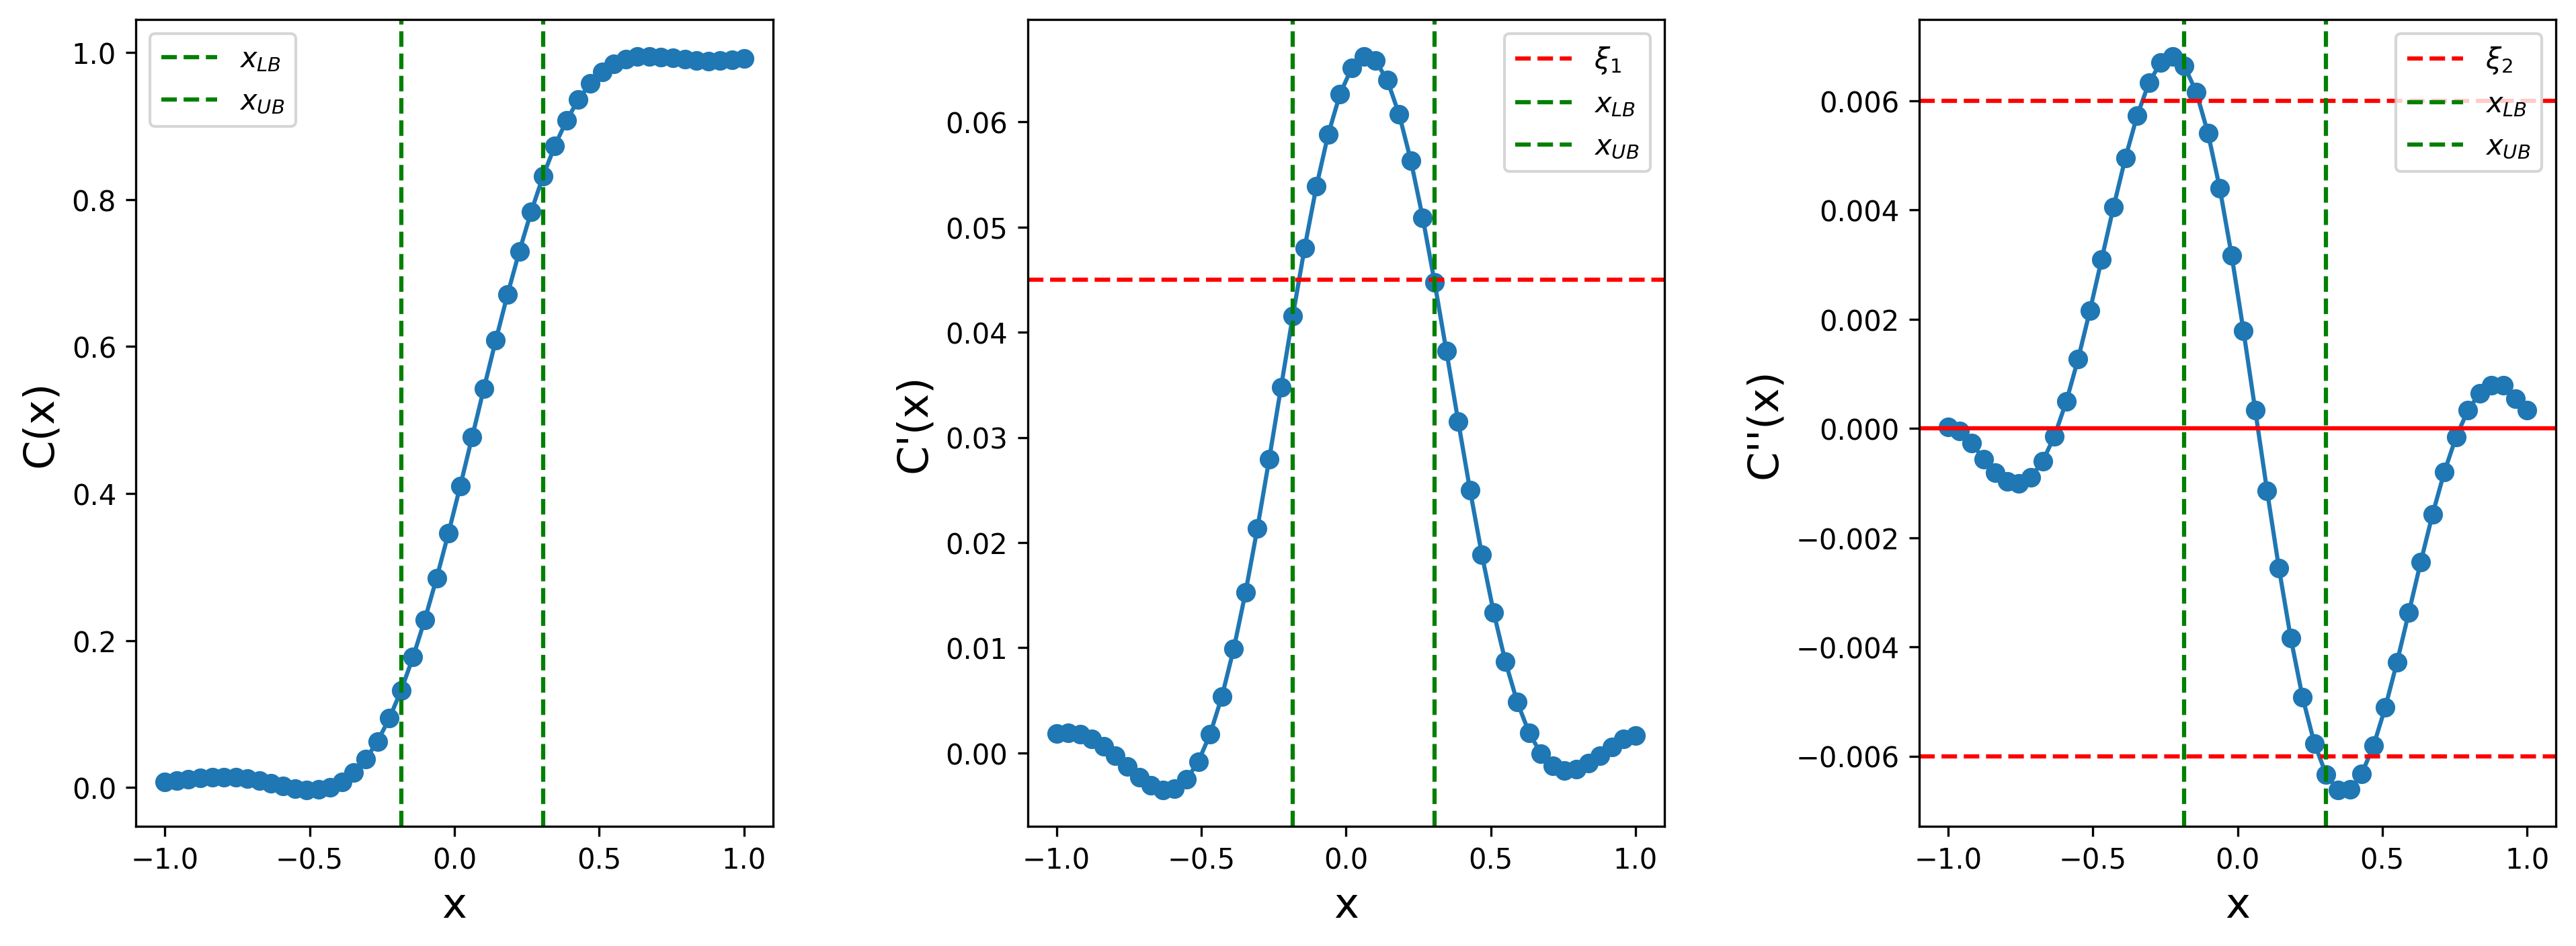

In [60]:
x_values = np.linspace(-c2-1, -c2+1, 50)
cdf = [C(x, D, moments, beta=beta) for x in x_values]

x_values = np.linspace(-1, 1, 50)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.rcParams["figure.figsize"] = (15,5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plt.subplot(131)
plt.plot(x_values, cdf)
plt.scatter(x_values, cdf)
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[32], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C(x)", size=15)
plt.legend()


plt.subplot(132)
cdf_dot = np.gradient(cdf)
plt.plot(x_values, cdf_dot)
plt.scatter(x_values, cdf_dot)
plt.axhline(0.045, color="red", ls="--", label=r"$\xi_1$")
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[32], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C'(x)", size=15)
plt.legend()

plt.subplot(133)
cdf_dot2 = np.gradient(cdf_dot)
plt.plot(x_values, cdf_dot2)
plt.axhline(0, color="red")
plt.axhline(6e-3, color="red", ls="--", label=r"$\xi_2$")
plt.axhline(-6e-3, color="red", ls="--")
plt.scatter(x_values, cdf_dot2)
plt.axvline(x_values[20], color="green", ls="--", label=r"$x_{LB}$")
plt.axvline(x_values[32], color="green", ls="--", label=r"$x_{UB}$")
plt.xlabel("x", size=15)
plt.ylabel("C''(x)", size=15)
plt.legend()

plt.show()

In [61]:
x_values = np.linspace(-c2-1, -c2+1, 50)
np.array([x_values[20], x_values[32]])/c1

array([-14.03581841, -11.43690129])

In [63]:
# Assumptions!
spectrum_upper_bound = -11.43690129
spectrum_lower_bound = -14.03581841
max_spectrum_length = spectrum_upper_bound - spectrum_lower_bound
c1 = (np.pi-2*dist) / (max_spectrum_length)
c2 = dist - c1 * spectrum_lower_bound

eigenvalues_tr = eigenvalues_sort * c1 + c2
a_values = np.array([np.cos(eig/2) for eig in eigenvalues_tr])
print(a_values[:5])
print(eigenvalues_tr[:6])
print("t: ", c1/2)
print("c2: ", c2)
print("Mu: ", np.cos((c1*(max_spectrum_length * 0.5 + spectrum_lower_bound)+c2)/2) )

[ 0.72754707-0.j  0.65908771-0.j  0.05831432-0.j -0.02747135-0.j
 -0.02747135-0.j]
[1.51211317+0.j 1.70238252+0.j 3.02489781+0.j 3.19654227+0.j
 3.19654227+0.j 4.4636415 +0.j]
t:  0.6044003153109003
c2:  16.966516145301078
Mu:  0.7071067811865476


In [64]:
mu, d, c, phis_max_iter, = (0.7, 30, 0.95, 10)
t = c1/2
qc_qetu, phis_0, _ = qetu_rqc_oneLayer(L, J, g, t, mu, a_values, d=d, c=c, 
                                           c2=c2, max_iter_for_phis=phis_max_iter,
                                           reuse_RQC=6, split_U=int(np.ceil(t)))
qcs_qetu.append(qc_qetu)

dt:  0.6044003153109003
coeffs_start_n5: [0.25, 0.5, 0.5, 0.5, 0.25]
Running decomposition of two-qubit gates of the RQC Circuit...
F(a_max)^2:  (0.5174514318347873+0j)
F(a_premax)^2:  (0.024184749488920295+0j)
F(x)^2:  0.23195649076856398


/var/folders/l5/dy5jxrx94_98nf6d030tcw640000gn/T/ipykernel_39905/956662549.py:6: DeprecationWarning: The function ``qiskit.execute_function.execute()`` is deprecated as of qiskit 0.46.0. It will be removed in the Qiskit 1.0 release. This function combines ``transpile`` and ``backend.run``, which is covered by ``Sampler`` :mod:`~qiskit.primitives`. Alternatively, you can also run :func:`.transpile` followed by ``backend.run()``.
  bR = execute(transpile(qc_RQC), backend).result().get_statevector().data


Success Prob:  0.0009648033003277033
 Overlap:  0.09685132399322802
Success Prob:  0.16042947524051637
 Overlap:  0.26864124487585994
Success Prob:  0.7486020659342043
 Overlap:  0.3153017025436835
Success Prob:  0.8294733817514346
 Overlap:  0.33398616843369244
Success Prob:  0.18888790608168057
 Overlap:  0.9147359137764095
Success Prob:  0.4755673086991828
 Overlap:  0.9951558100350245


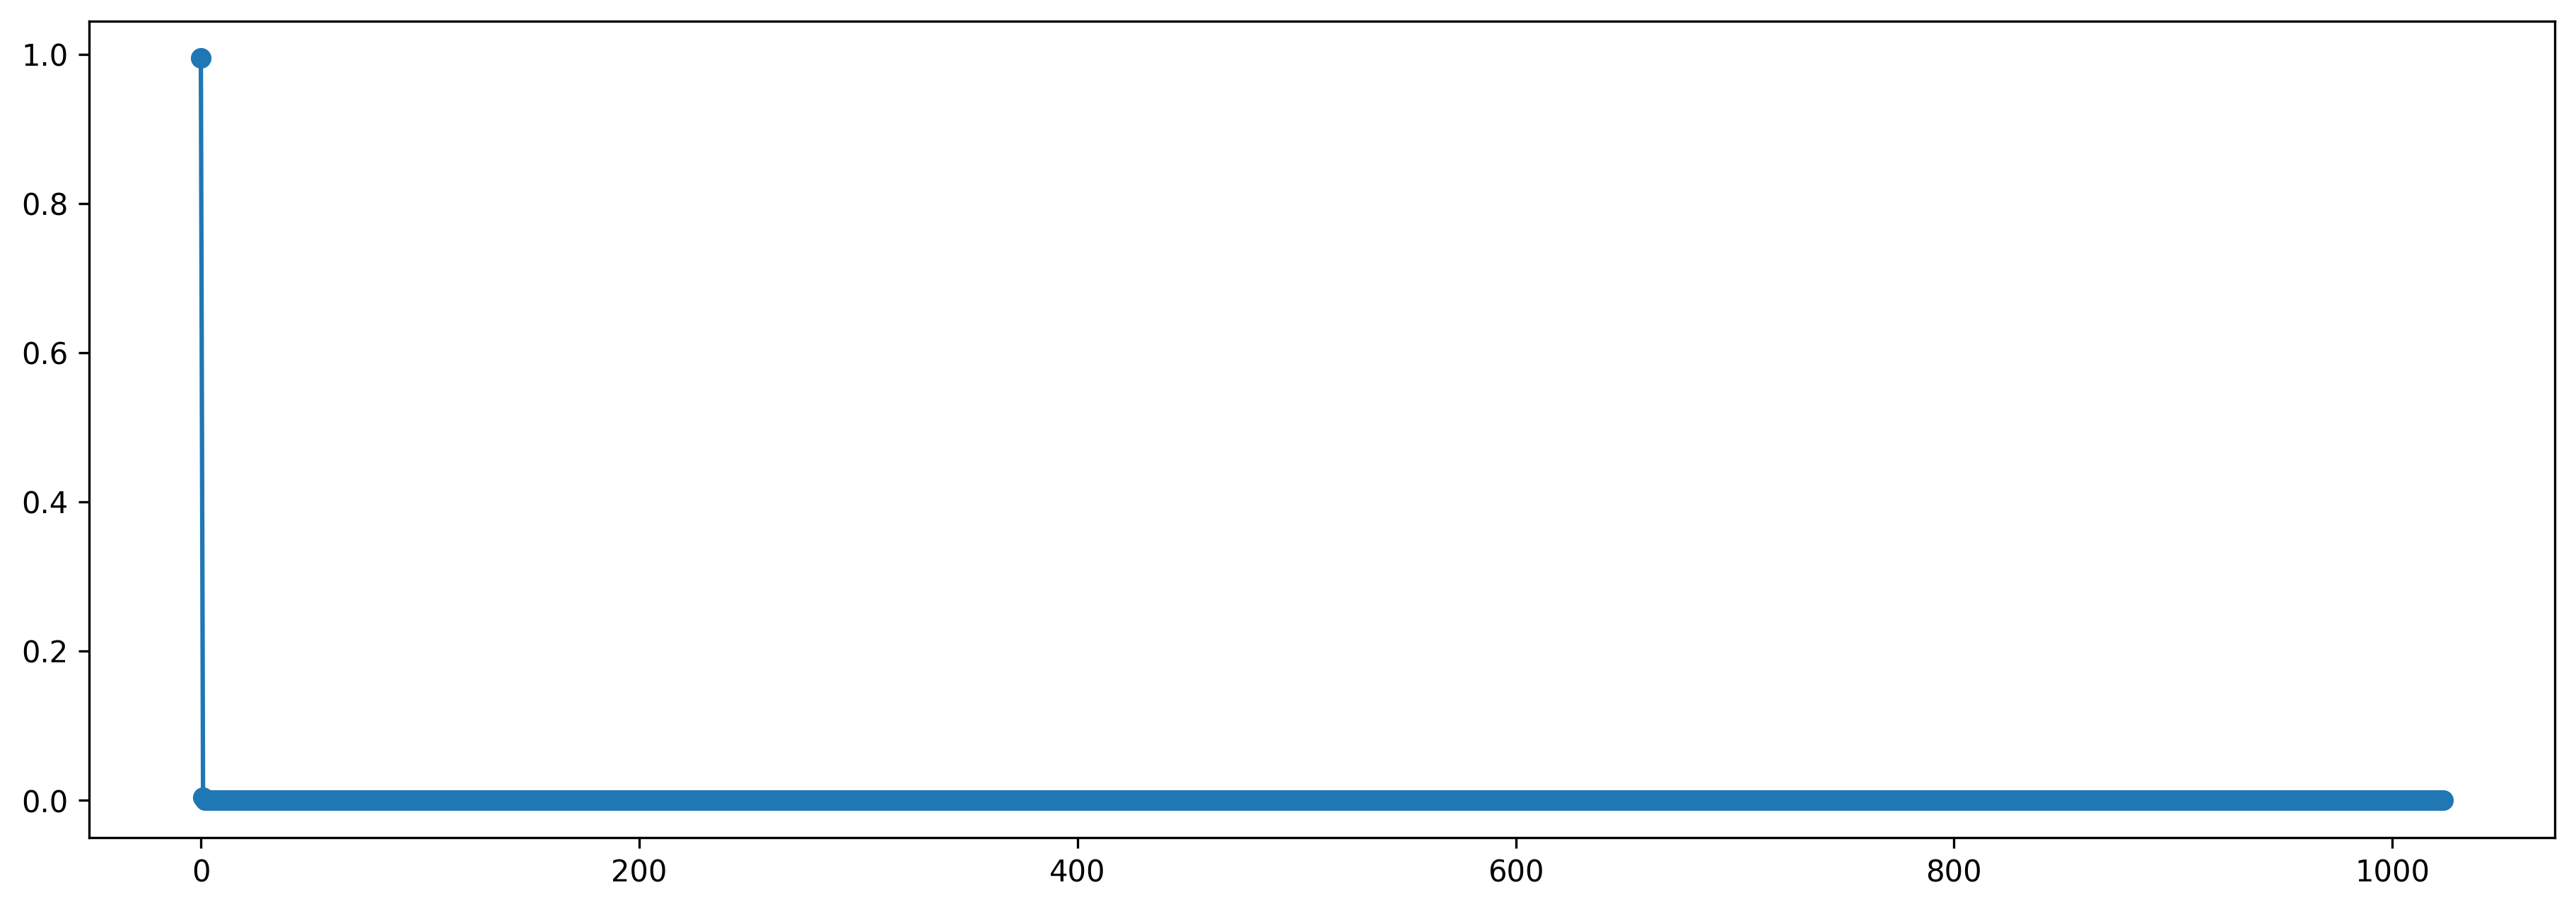

In [67]:
backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, L+1)
qc_RQC.initialize(np.kron(ket_0, vec))
for qc_qetu in qcs_qetu + [qcs_qetu[-1]]:
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    print("Success Prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)
    print(" Overlap: ", state_fidelity(aR[:2**L], eigenvectors_sort[:, 0]))
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)

toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(2**L)]
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)
plt.show()

In [ ]:
backend = Aer.get_backend("statevector_simulator")
qc_RQC = qiskit.QuantumCircuit(L+1, L+1)
qc_RQC.initialize(np.kron(ket_0, vec))
overlaps_static2 = []
for qc_qetu in [qcs_qetu[0] for i in range(50)]:
    qc_RQC.append(qc_qetu.to_gate(), [i for i in range(L+1)])
    bR = execute(transpile(qc_RQC), backend).result().get_statevector().data
    aR = np.kron(np.array([[1,0],[0,0]]), np.identity(2**L)) @ bR
    print("Success Prob: ", np.linalg.norm(aR)**2)
    aR = aR / np.linalg.norm(aR)
    overlaps_static2.append(state_fidelity(aR[:2**L], eigenvectors_sort[:, 0]))
    print(" Overlap: ", state_fidelity(aR[:2**L], eigenvectors_sort[:, 0]))
    qc_RQC.reset([i for i in range(L+1)])
    qc_RQC.initialize(aR)

toPlot = [state_fidelity(aR[:2**L], eigenvectors_sort[:, i]) for i in range(2**L)]
plt.plot([i for i in range(len(toPlot))], toPlot)
plt.scatter([i for i in range(len(toPlot))], toPlot)
plt.show()

In [79]:
overlaps_AFF = [0.0968, 0.268, 0.3153, 0.3339, 0.914, 0.995]
gammas_AFF = np.array([0.039, 0.039, 0.1480,  0.604, 0.039, 0.604])
gammas_AFF = [np.sum(gammas_AFF[:i+1]) for i in range(len(gammas_AFF))]
gammas_ST = [0.039*i for i in range(50)] 

rqc_opt_layers_AFF = np.array([3, 6, 11, 18, 21, 28])*30
rqc_opt_layers_ST = [30*3*i for i in range(1, len(overlaps_static2)+1)]

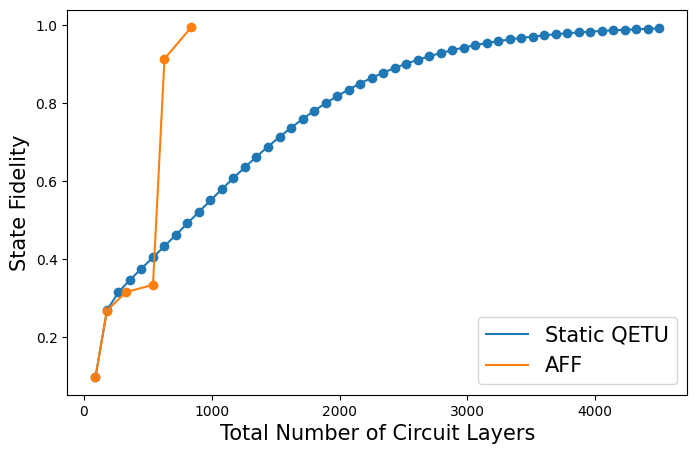

In [83]:
plt.rcParams["figure.figsize"] = (8,5)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

plt.plot(rqc_opt_layers_ST, overlaps_static2, label="Static QETU")
plt.scatter(rqc_opt_layers_ST, overlaps_static2)

plt.plot(rqc_opt_layers_AFF, overlaps_AFF, label="AFF")
plt.scatter(rqc_opt_layers_AFF, overlaps_AFF)
plt.xlabel("Total Number of Circuit Layers", size=15)
plt.ylabel("State Fidelity", size=15)
plt.legend(prop={'size': 15})
plt.savefig("../../figs/TFIM10_layers.pdf")
plt.show()

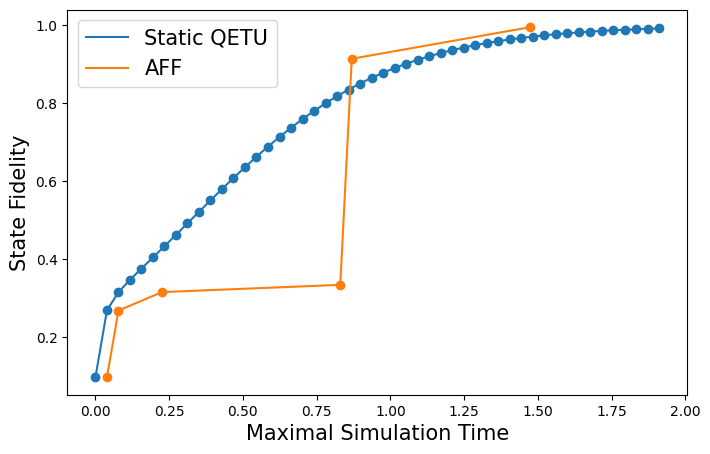

In [82]:
plt.plot(gammas_ST, overlaps_static2, label="Static QETU")
plt.scatter(gammas_ST, overlaps_static2)

plt.plot(gammas_AFF, overlaps_AFF, label="AFF")
plt.scatter(gammas_AFF, overlaps_AFF)


plt.xlabel("Maximal Simulation Time", size=15)
plt.ylabel("State Fidelity", size=15)
plt.legend(prop={'size': 15})
plt.savefig("../../figs/TFIM10_tmax.pdf")
plt.show()